In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
portfolio = pd.read_json(r'C:\Desktop\portfolio.json', orient='records', lines=True)
profile = pd.read_json(r'C:\Desktop\profile.json', orient='records', lines=True)
transcript = pd.read_json(r'C:\Desktop\transcript.json', orient='records', lines=True)

In [3]:
df=pd.DataFrame(transcript['value'].values.tolist(),index=transcript.index)

In [4]:
transcript=transcript.merge(df,left_index=True, right_index=True)

In [5]:
#one hot encode channels
mlb = MultiLabelBinarizer()
channel = pd.DataFrame(mlb.fit_transform(portfolio['channels']),columns=mlb.classes_, index=portfolio.index)

In [6]:
portfolio=portfolio.merge(channel,left_index=True, right_index=True)

In [7]:
transcript=transcript.merge(portfolio, left_on='offer_id', right_on='id', how='left')

In [8]:
#offers completed
offers_complete_ct=transcript[(transcript['event']=='offer completed')]\
            .groupby(['offer_type'])['offer_id'].count()
offers_complete_ct

offer_type
bogo        15669
discount    17910
Name: offer_id, dtype: int64

In [9]:
#To get offers viewed by offer_type, do another join
transcript=transcript.merge(portfolio, left_on='offer id', right_on='id', how='left')

In [10]:
#offers viewed
offers_view_ct=transcript[(transcript['event']=='offer viewed') &\
                         (transcript['offer_type_y']!='informational')].groupby(['offer_type_y'])['offer id'].count()
offers_view_ct

offer_type_y
bogo        25449
discount    21445
Name: offer id, dtype: int64

#### I want to compare business metrics to see how much improvement there can be by engaging users in reward offers.
#### Conversion Rate=Number of Offers Completed / Number of Offers Viewed

In [11]:
round(offers_complete_ct/offers_view_ct*100,1)

offer_type
bogo        61.6
discount    83.5
dtype: float64

#### Takeaway: If user views the rewards offer, their response rate is higher for discount than bogo offers.

#### Direct Response Rate= Number of Offers Completed / Number of Offers Received 

In [12]:
#offers viewed
offers_receive_ct=transcript[(transcript['event']=='offer received') &\
                         (transcript['offer_type_y']!='informational')].groupby(['offer_type_y'])['offer id'].count()
offers_receive_ct

offer_type_y
bogo        30499
discount    30543
Name: offer id, dtype: int64

In [13]:
df=pd.DataFrame(round(offers_complete_ct/offers_receive_ct*100,1))

In [14]:
df.columns =['offers_received_response_rate']
df

,offers_received_response_rate
offer_type,
bogo,51.4
discount,58.6


In [15]:
df['offers_viewed_response_rate']=(round(offers_complete_ct/offers_view_ct*100,1))

In [16]:
df=df.reset_index()

In [17]:
df_unpivoted=df.melt(id_vars=['offer_type'],var_name='Response Rate Definition',value_name='Response Rate Percentage')
df_unpivoted

,offer_type,Response Rate Definition,Response Rate Percentage
0,bogo,offers_received_response_rate,51.4
1,discount,offers_received_response_rate,58.6
2,bogo,offers_viewed_response_rate,61.6
3,discount,offers_viewed_response_rate,83.5


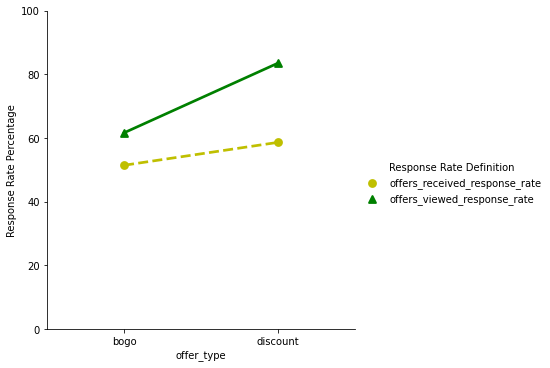

In [18]:
ax=sns.catplot(
    data=df_unpivoted, x="offer_type", y="Response Rate Percentage", hue="Response Rate Definition",
    palette={"offers_received_response_rate": "y", "offers_viewed_response_rate": "g"},
    markers=["o", "^"], linestyles=["--", "-"],
    kind="point"
)

ax.set(ylim=(0, 100))
plt.show()

In [19]:
df['pct_diff']=df['offers_viewed_response_rate']-df['offers_received_response_rate']
df['pct_diff']=df['pct_diff']

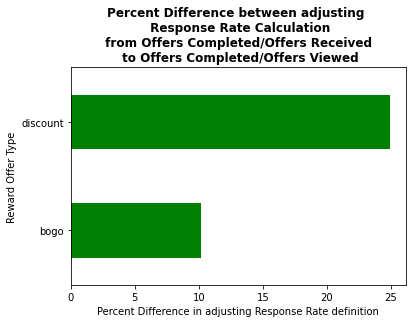

In [20]:
df[['offer_type','pct_diff']].plot(x='offer_type',
        kind='barh',legend=False,
        stacked=False,color='green')
                                   
                                   
plt.title('Percent Difference between adjusting \n Response Rate Calculation\n from Offers Completed/Offers Received \n to Offers Completed/Offers Viewed',
                              weight='bold')
plt.ylabel('Reward Offer Type')
plt.xlabel('Percent Difference in adjusting Response Rate definition')
plt.show()

#### Discount offers have a higher response rate and a higher likelihood of completion conditional on being viewed.